In [15]:
# !pip install -q git+https://github.com/samoturk/mol2vec;

In [16]:
# !pip install -q huggingface-hub transformers catboost xgboost lightgbm torch gensim==3.7.1

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import PreprocessSMILES, SimpleRegressions, SmallNN, LstmRegressor, DataLoader, Training

from utils import load_config, seed_everything

import gensim

print(gensim.__version__) # 3.7.1

3.7.1


## Майнинг данных из SMILES и объединение молекул в смеси

In [18]:

from pandas.core.frame import DataFrame


descriptors: DataFrame = pd.read_csv(filepath_or_buffer='./materials/descriptors.csv')
descriptors_test: DataFrame = pd.read_csv(filepath_or_buffer='./materials/descriptors_test.csv')

common_columns = list(set(descriptors.columns) & set(descriptors_test.columns))

filtered_descriptors = descriptors[common_columns]
filtered_descriptors_test = descriptors_test[common_columns]

filtered_descriptors.to_csv(path_or_buf='./materials/descriptors.csv', index=False)
filtered_descriptors_test.to_csv(path_or_buf='./materials/descriptors_test.csv', index=False)

In [19]:
############################################################################################################################################
################################################# TRAIN ####################################################################################
directory = './materials/'
preprocessor = PreprocessSMILES(directory, 'canonical_smiles')
mdf = preprocessor.preprocess_data("train_data_fix_concat.csv", "descriptors.csv")
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentence(mdf, "train")
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df = preprocessor.embed_smiles(joined_df, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df.reset_index(drop=True, inplace=True)
mdf['graphs'] = preprocessor.generate_graphs(mdf)
mdf.drop(columns=['oil_property_param_value', 'mol'], inplace=True)
joined_df.head(3)
# X, y = preprocessor.xy_split(joined_df, column = 'embeddings')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.weight', 'regression.out_proj.bias', 'regression.dense.bias', 'regression.out_proj.weight', 'norm_mean', 'norm_std']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,canonical_smiles,smiles,descriptors_array,oil_property_param_value,similarity_vectors,embeddings
0,007b4d7a-b1f8-11ed-93b4-005056921581,"[2246728737, 3537119515, 2245273601, 242354360...","[-3.4431674, -0.62736166, -2.157891, -0.715889...","CCCCCC(C)C, CCCC(C)CCC, CCCCC","CC(C)CCCCC, CCCC(C)CCC, CCCCC","[0.0, 261.36, 0.0, 0.0, 1678.522199270234, 0.0...",13360.0,"[0.3888888888888889, 0.4, 0.2857142857142857]","[-0.0811089351773262, -0.0713161751627922, 0.0..."
1,0109d480-f91d-11ec-96ac-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-5.5208826, 0.3777768, -3.6566508, -1.7744193...","CCCCC(C)CC, CCCC(C)CCC, CCCCC, CCCCC(C)C, CCCC...","CCC(C)CCCC, CCCC(C)CCC, CCCCC, CCCCC(C)C, O=C(...","[0.0, 435.6, 0.0, 0.0, 2797.5369987837234, 0.0...",111400.0,"[0.4444444444444444, 0.375, 0.5555555555555556...","[-0.10297797620296478, -0.061806902289390564, ..."
2,01bc9ed0-0f2f-11ed-9900-005056921581,"[2246728737, 3542456614, 2245384272, 150656359...","[-2.5844321, 0.054932743, -2.082138, -0.734171...","CCC(CC)C(=O)OC, CCCC(C)CCC, CCCCC","CCC(C(OC)=O)CC, CCCC(C)CCC, CCCCC","[0.0, 261.36, 0.0, 0.0, 1678.522199270234, 0.0...",16325.0,"[0.16666666666666666, 0.14285714285714285, 0.2...","[-0.1449631303548813, -0.014604375697672367, 0..."


In [20]:
##################################################################################################################
############################################### TEST ################################################################
preprocessor_test = PreprocessSMILES(directory=directory, base_on='canonical_smiles', task = 'test')
mdf_test = preprocessor_test.preprocess_data("test_data_fix_concat.csv", "descriptors_test.csv")
grouped_mdf_test = preprocessor_test.preprocess_mol2vec(mdf_test)
smiles_df_test = preprocessor_test.smiles2sentence(mdf_test)
joined_df_test = pd.merge(grouped_mdf_test, smiles_df_test, on='blend_id', how='inner').dropna() # TODO: fix nan
joined_df_test = preprocessor_test.embed_smiles(joined_df_test, 'DeepChem/ChemBERTa-10M-MTR') # ibm/MoLFormer-XL-both-10pct DeepChem/ChemBERTa-10M-MTR
joined_df_test.reset_index(drop=True, inplace=True)
mdf_test['graphs'] = preprocessor_test.generate_graphs(mdf_test)
mdf_test.drop(columns=['mol'], inplace=True)
joined_df_test.head(3)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Some weights of the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0a6af3156071d9519e867d695aa265bb393f were not used when initializing RobertaModel: ['regression.dense.weight', 'regression.out_proj.bias', 'regression.dense.bias', 'regression.out_proj.weight', 'norm_mean', 'norm_std']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./materials/embed_model/DeepChem/ChemBERTa-10M-MTR/models--DeepChem--ChemBERTa-10M-MTR/snapshots/b65d0

,blend_id,sentence,mol2vec,canonical_smiles,smiles,descriptors_array,similarity_vectors,embeddings
0,0189e1f2-2ab8-11ee-8be1-005056921581,"[2246728737, 3542456614, 2245384272, 117312591...","[-2.5093365, -0.48656785, -1.1924767, -0.49072...","CCCC(C)CCC, CCCCCCC","CCCC(C)CCC, CCCCCCC","[0.0, 87.12000000000002, 0.0, 0.0, 559.5073997...",[0.26666666666666666],"[-0.08549749851226807, -0.061702728271484375, ..."
1,02114c6e-eb16-11ed-9974-005056921581,"[2246728737, 3537119515, 2245273601, 84546060,...","[-6.4228168, -1.2596623, -4.4797096, -2.153883...","CCCCOC(=O)C(C)C(=O)OCCCC, CCCCCCCC(C)C(CCCCCC)...","CC(C(OCCCC)=O)C(OCCCC)=O, CCCCCCC(C(C)CCCCCCC)...","[0.0, 87.12000000000002, 0.0, 0.0, 559.5073997...",[0.22857142857142856],"[0.004265304654836655, 0.04065549746155739, -0..."
2,03ac1c22-6af9-11ed-8d22-005056921581,"[2246728737, 3537123720, 2245277810, 170459982...","[-11.42185, -0.05583578, -8.702778, 0.75527394...","COC(=O)C(C)(C)C, CCCCCC(C)C, CCCC(CC(C)(CC)C(=...","CC(C)(C)C(OC)=O, CC(C)CCCCC, CCC(C(OC)=O)(CC(C...","[0.0, 217.80000000000004, 0.0, 0.0, 1398.76849...","[0.037037037037037035, 0.2894736842105263, 0.0...","[0.033982302993535995, 0.027752717956900597, 0..."


In [21]:
print(len(joined_df_test['descriptors_array'][100]))
print(len(joined_df['descriptors_array'][100]))

1097
1097


In [22]:
# TODO: пример графа, на данный момент не используется

mdf['graphs'][0]

Graph(num_nodes=8, num_edges=14,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

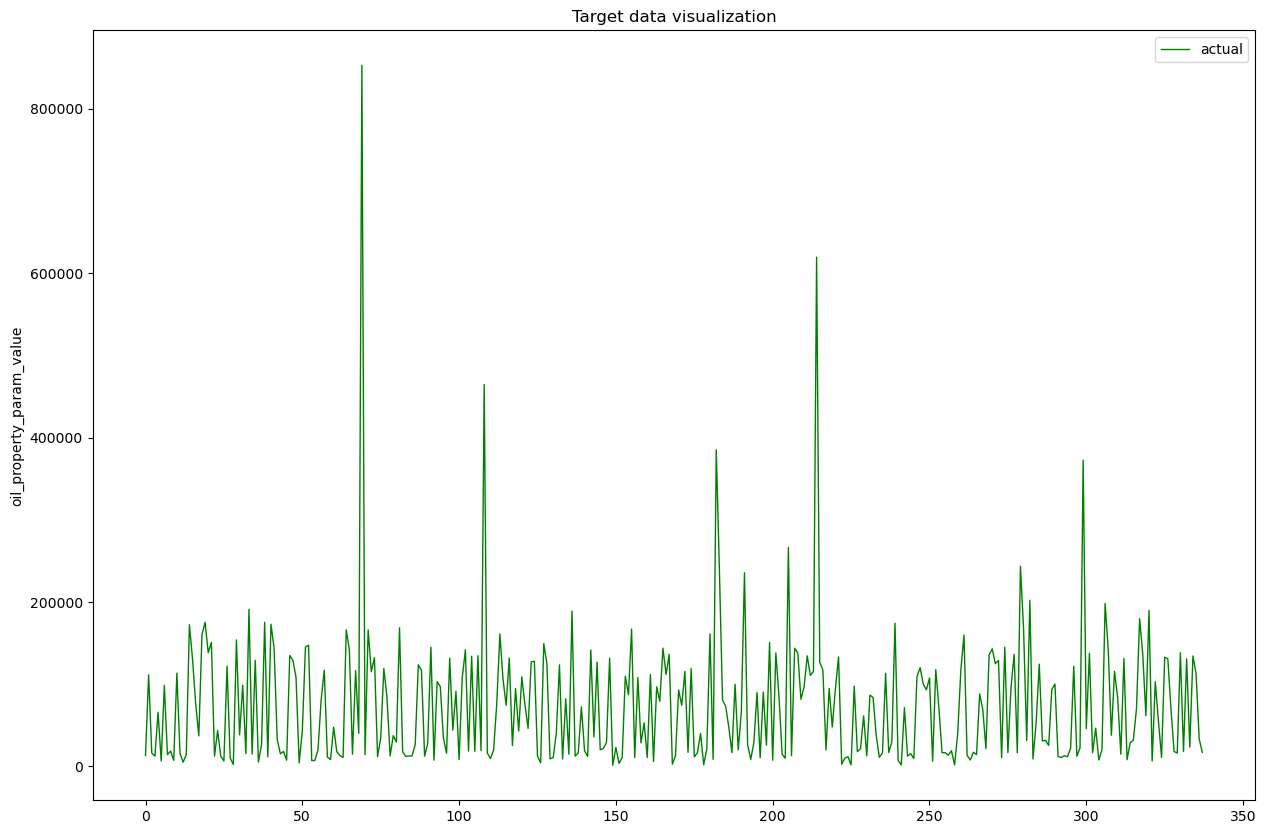

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(joined_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Target data visualization")
plt.show()


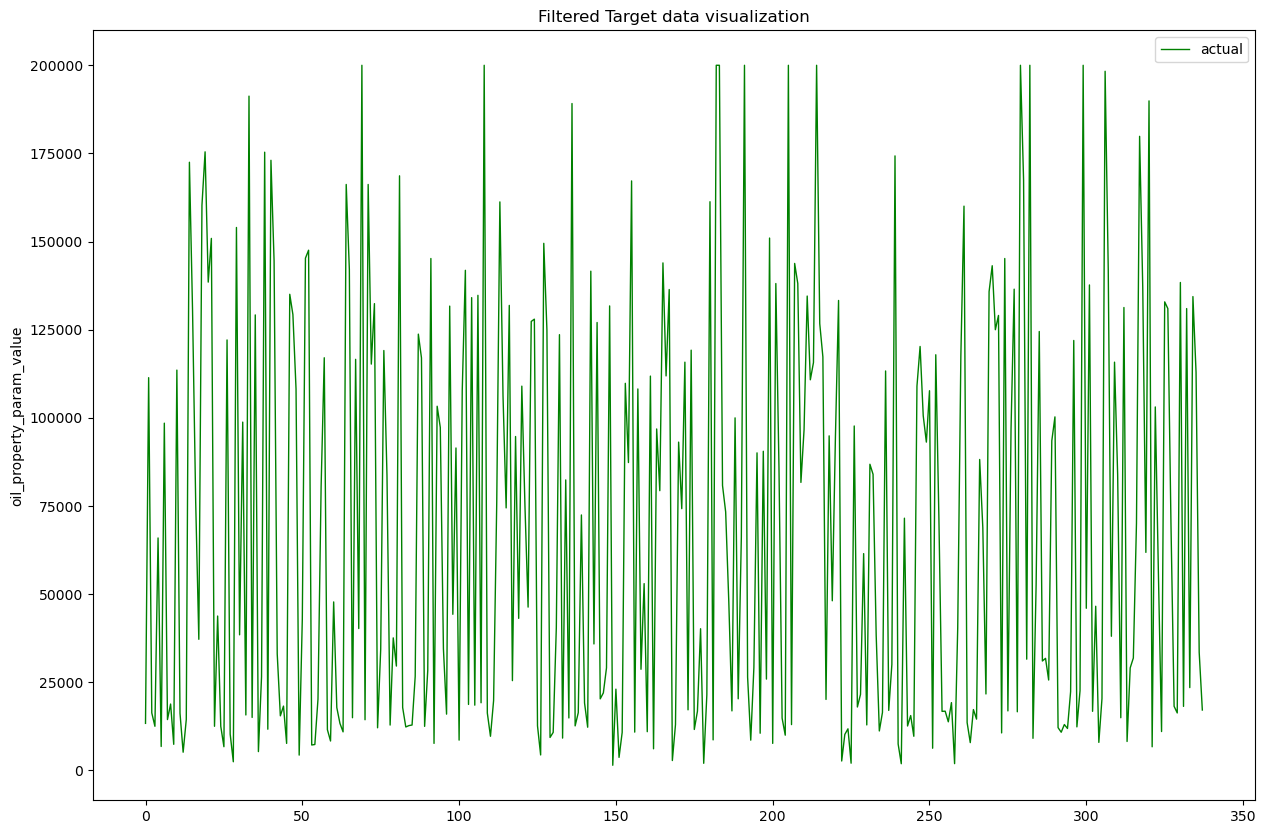

In [24]:
## Обработка выбросов для обучения

joined_df['oil_property_param_value'] = joined_df['oil_property_param_value'].apply(lambda x: min(x, 200000))
plt.figure(figsize=(15, 10))
plt.plot(joined_df['oil_property_param_value'], "green", label="actual", linewidth=1.0)
plt.legend()
plt.ylabel("oil_property_param_value")
plt.title("Filtered Target data visualization")
plt.show()

## Подготовка данных для обучения на объединенных последовательностях векторов, эмбедингов смеси и близости расстояний между молекулами.


In [25]:
# как similarity_score используется TanimotoSimilarity из rdkit

static_cols = ['embeddings'] #['mol2vec', 'embeddings', 'descriptors_array']
dynamic_cols = ['similarity_vectors'] #['similarity_vectors']

########################################## TRAIN DATALOADER ######################################################

data_loader = DataLoader(joined_df, static_cols, dynamic_cols)
dataset = data_loader.get_dataset()

########################################## TEST DATALOADER  ######################################################

test_data_loader = DataLoader(joined_df_test, static_cols, dynamic_cols, task = 'test')
test_dataset, _ = test_data_loader.get_dataset()

Shape of data_x: (338, 1, 390)
Shape of data_y: (338, 1)
Shape of data_x: (138, 1, 390)


## Тренировка

In [26]:
# Тренировка 3 архитектур нейросеток

# config = load_config("config.yml", "embeddings", "torchRegressor")
# seed_everything()
# trainer = Training(config, dataset.data_x, y=dataset.data_y, test_X = test_dataset.data_x, cross_validation = False)

# pred1 = trainer.average_prediction()
# pred2 = trainer.weighted_average_prediction(model_wise=[0.29, 0.33, 0.38], fold_wise=[0.30, 0.35, 0.35])

-----Seed Set!-----
lr 0.005
BEST ----> 
GRURegressor Epoch 0, train_loss 1.085, val_loss 1.234, val_mae 59084.25390625
BEST ----> 
GRURegressor Epoch 1, train_loss 0.859, val_loss 0.908, val_mae 49844.29296875
BEST ----> 
GRURegressor Epoch 2, train_loss 0.846, val_loss 0.869, val_mae 47693.7734375
BEST ----> 
GRURegressor Epoch 3, train_loss 0.825, val_loss 0.84, val_mae 45578.41015625
GRURegressor Epoch 4, train_loss 0.777, val_loss 0.845, val_mae 45430.8671875
GRURegressor Epoch 5, train_loss 0.757, val_loss 0.796, val_mae 39221.65625
BEST ----> 
GRURegressor Epoch 6, train_loss 0.742, val_loss 0.772, val_mae 41090.87890625
BEST ----> 
GRURegressor Epoch 7, train_loss 0.694, val_loss 0.712, val_mae 37013.765625
GRURegressor Epoch 8, train_loss 0.684, val_loss 0.74, val_mae 38250.96484375
GRURegressor Epoch 9, train_loss 0.72, val_loss 0.829, val_mae 44463.0234375
GRURegressor Epoch 10, train_loss 0.713, val_loss 1.035, val_mae 48816.375
BEST ----> 
GRURegressor Epoch 11, train_loss

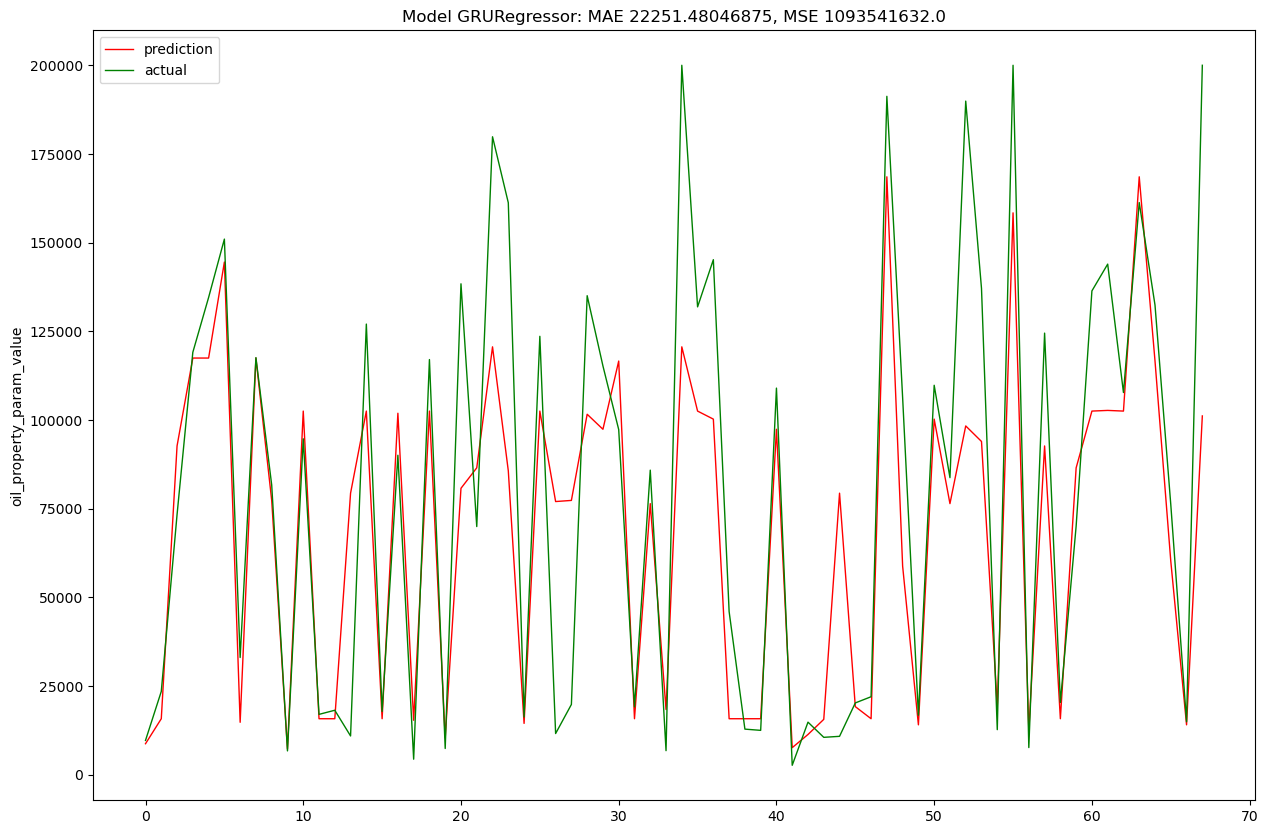

MAE score: 22251.484
MSE score: 1093541600.0


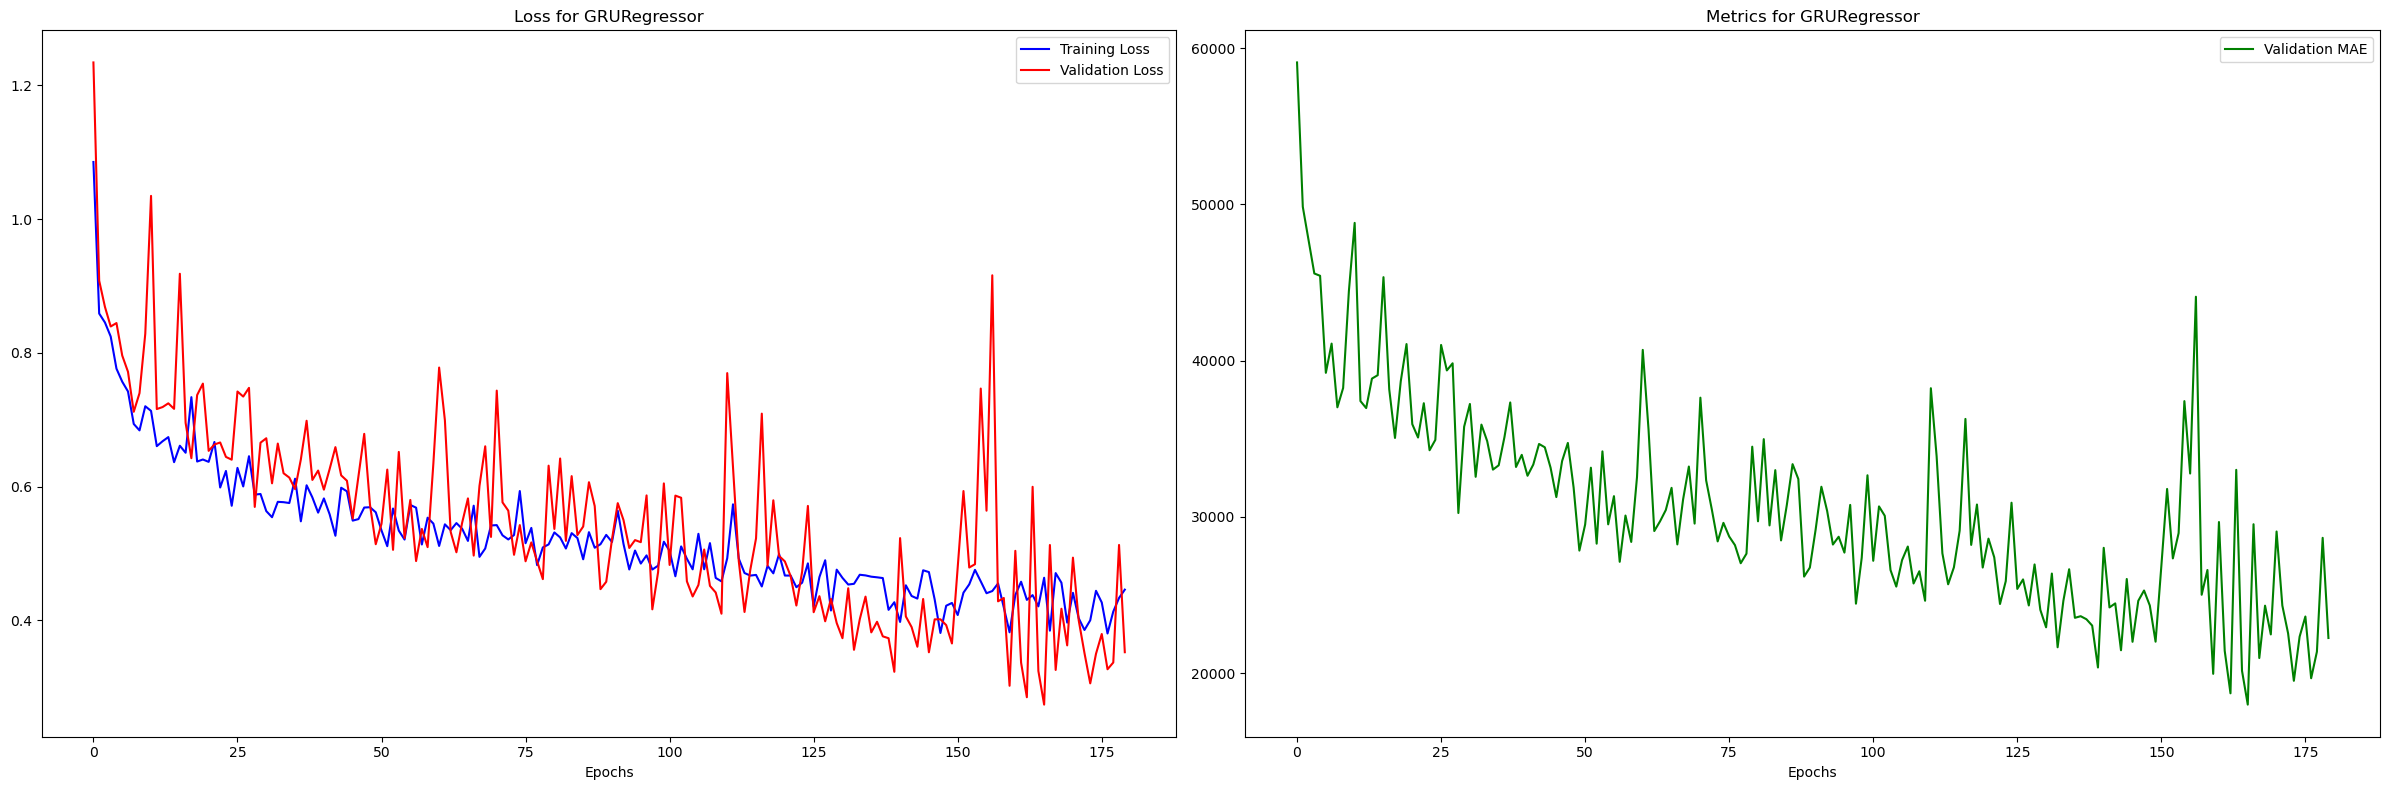

lr 0.02
BEST ----> 
ConvRegressor Epoch 0, train_loss 1.876, val_loss 1.319, val_mae 61862.05078125
BEST ----> 
ConvRegressor Epoch 1, train_loss 1.281, val_loss 1.041, val_mae 56568.9140625
ConvRegressor Epoch 2, train_loss 1.205, val_loss 1.126, val_mae 58666.828125
ConvRegressor Epoch 3, train_loss 1.039, val_loss 3.226, val_mae 117274.265625
BEST ----> 
ConvRegressor Epoch 4, train_loss 1.69, val_loss 1.018, val_mae 55773.23828125
ConvRegressor Epoch 5, train_loss 1.449, val_loss 1.071, val_mae 57461.26953125
ConvRegressor Epoch 6, train_loss 1.563, val_loss 3.299, val_mae 119297.8984375
BEST ----> 
ConvRegressor Epoch 7, train_loss 1.304, val_loss 1.015, val_mae 55664.109375
ConvRegressor Epoch 8, train_loss 1.051, val_loss 1.106, val_mae 58275.33984375
ConvRegressor Epoch 9, train_loss 0.92, val_loss 1.086, val_mae 57816.8046875
ConvRegressor Epoch 10, train_loss 0.919, val_loss 1.122, val_mae 58590.89453125
ConvRegressor Epoch 11, train_loss 0.921, val_loss 1.135, val_mae 58852.

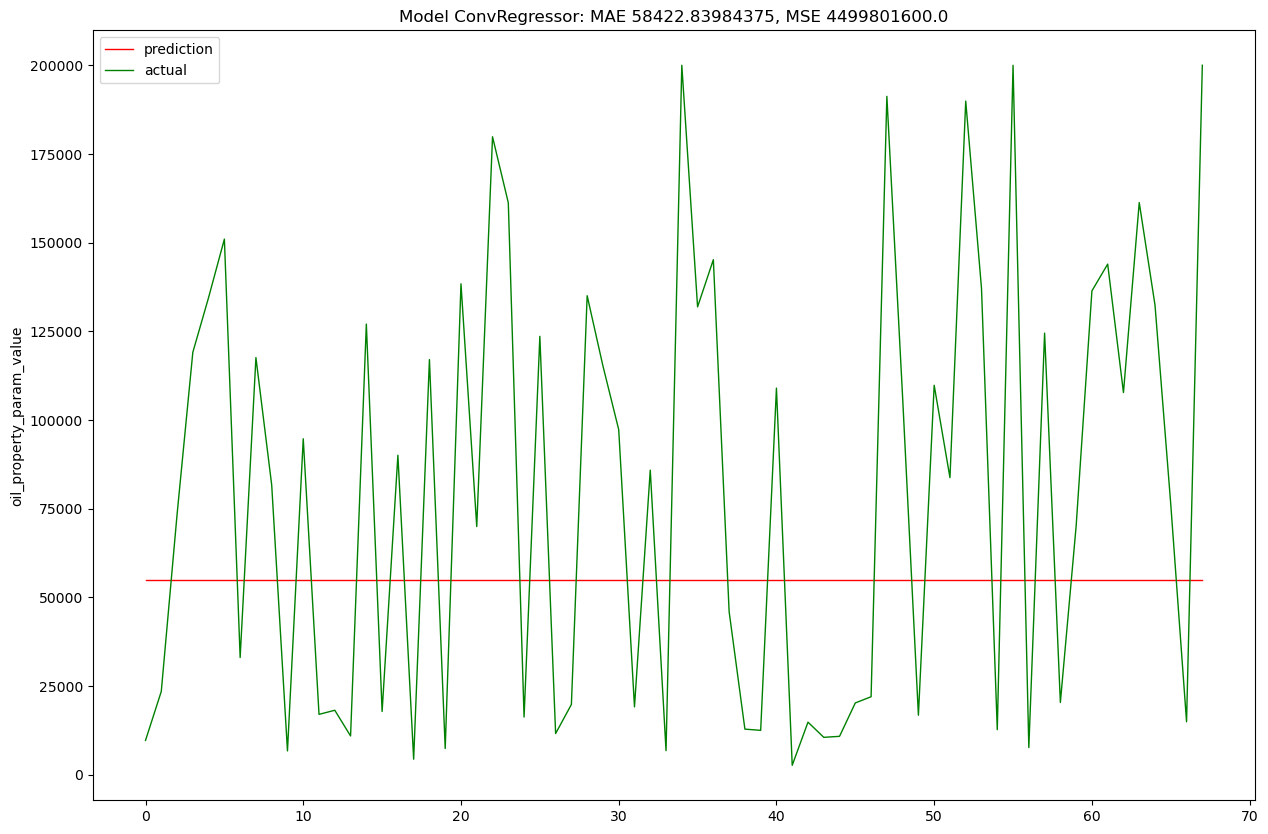

MAE score: 58422.84
MSE score: 4499801600.0


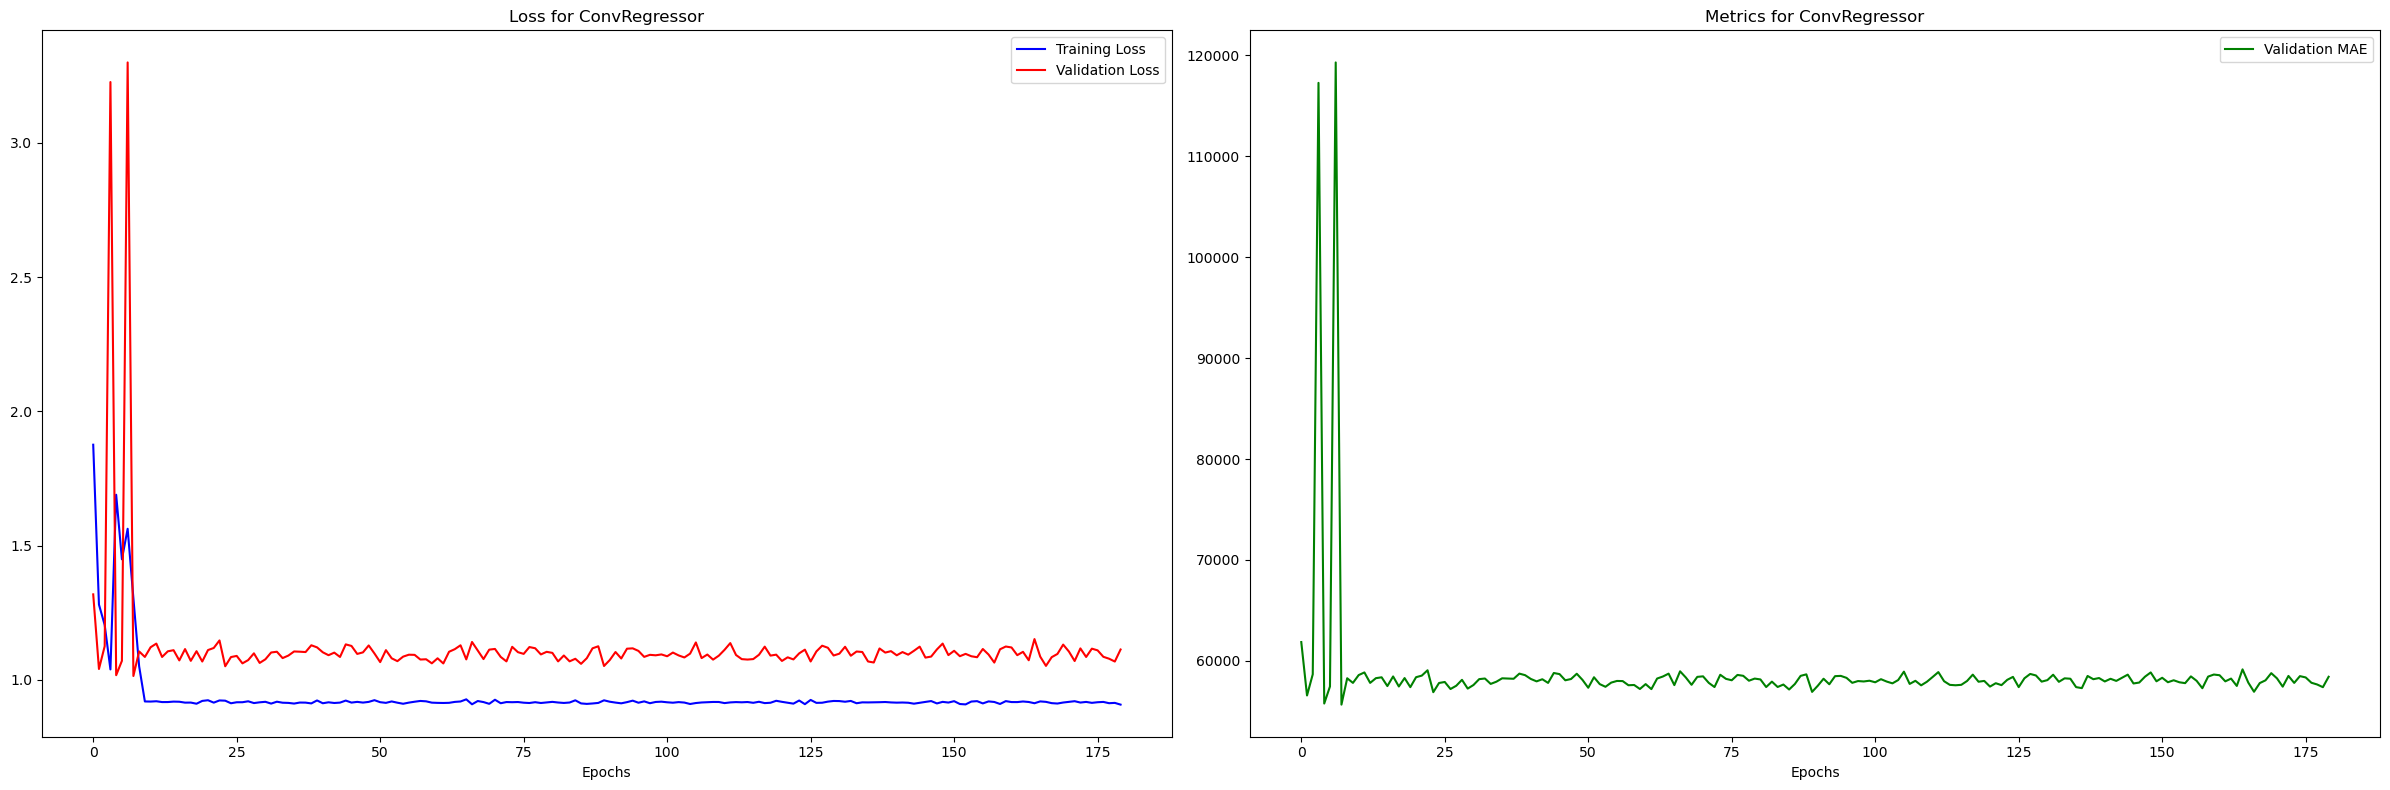

lr 0.02
BEST ----> 
LSTMRegressor Epoch 0, train_loss 1.381, val_loss 1.158, val_mae 59002.71875
LSTMRegressor Epoch 1, train_loss 1.083, val_loss 1.174, val_mae 59472.86328125
BEST ----> 
LSTMRegressor Epoch 2, train_loss 0.935, val_loss 1.089, val_mae 57881.36328125
BEST ----> 
LSTMRegressor Epoch 3, train_loss 0.916, val_loss 1.065, val_mae 57282.97265625
BEST ----> 
LSTMRegressor Epoch 4, train_loss 0.923, val_loss 1.059, val_mae 57124.42578125
LSTMRegressor Epoch 5, train_loss 0.926, val_loss 1.063, val_mae 57253.6640625
LSTMRegressor Epoch 6, train_loss 0.915, val_loss 1.115, val_mae 58464.78125
LSTMRegressor Epoch 7, train_loss 0.918, val_loss 1.123, val_mae 58623.96875
LSTMRegressor Epoch 8, train_loss 0.921, val_loss 1.106, val_mae 58260.1875
LSTMRegressor Epoch 9, train_loss 0.915, val_loss 1.071, val_mae 57451.7578125
BEST ----> 
LSTMRegressor Epoch 10, train_loss 0.919, val_loss 1.054, val_mae 56995.18359375
LSTMRegressor Epoch 11, train_loss 0.917, val_loss 1.099, val_mae 

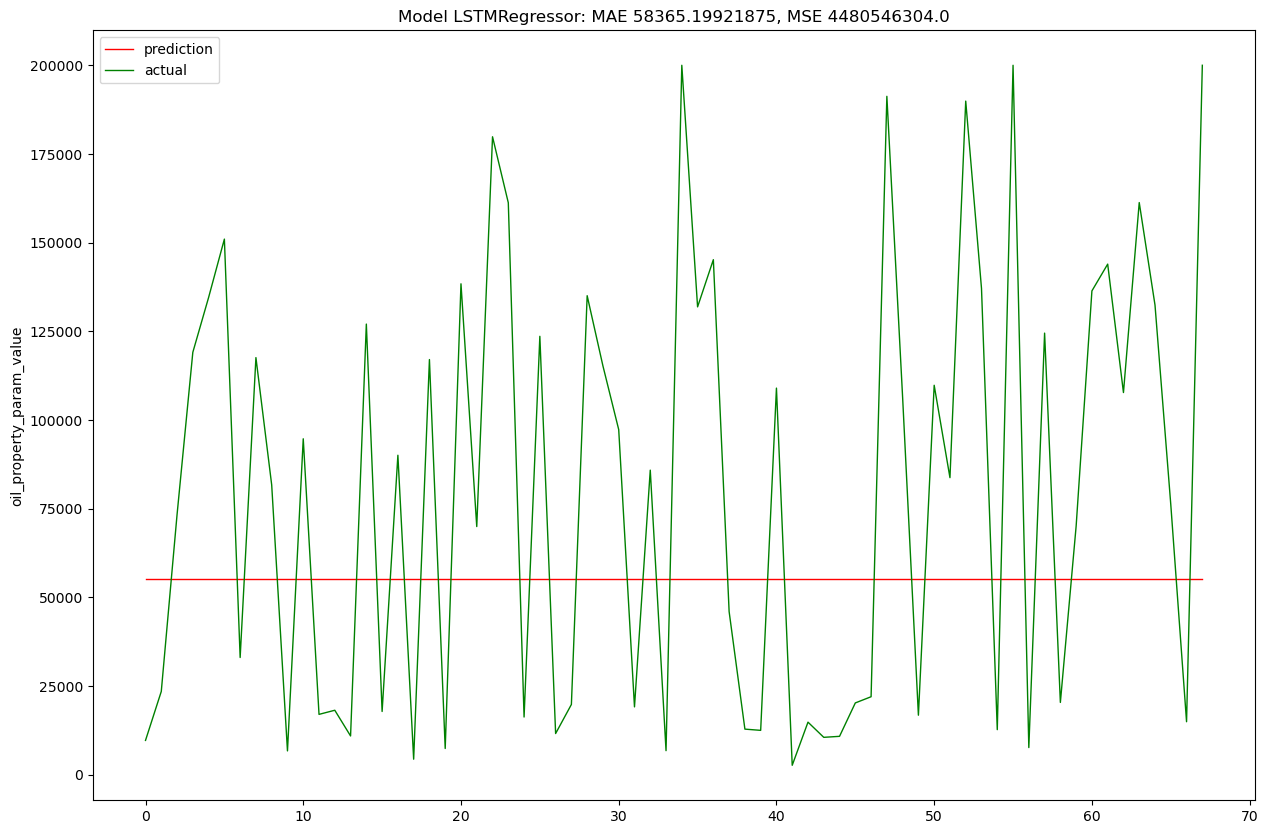

MAE score: 58365.203
MSE score: 4480546300.0


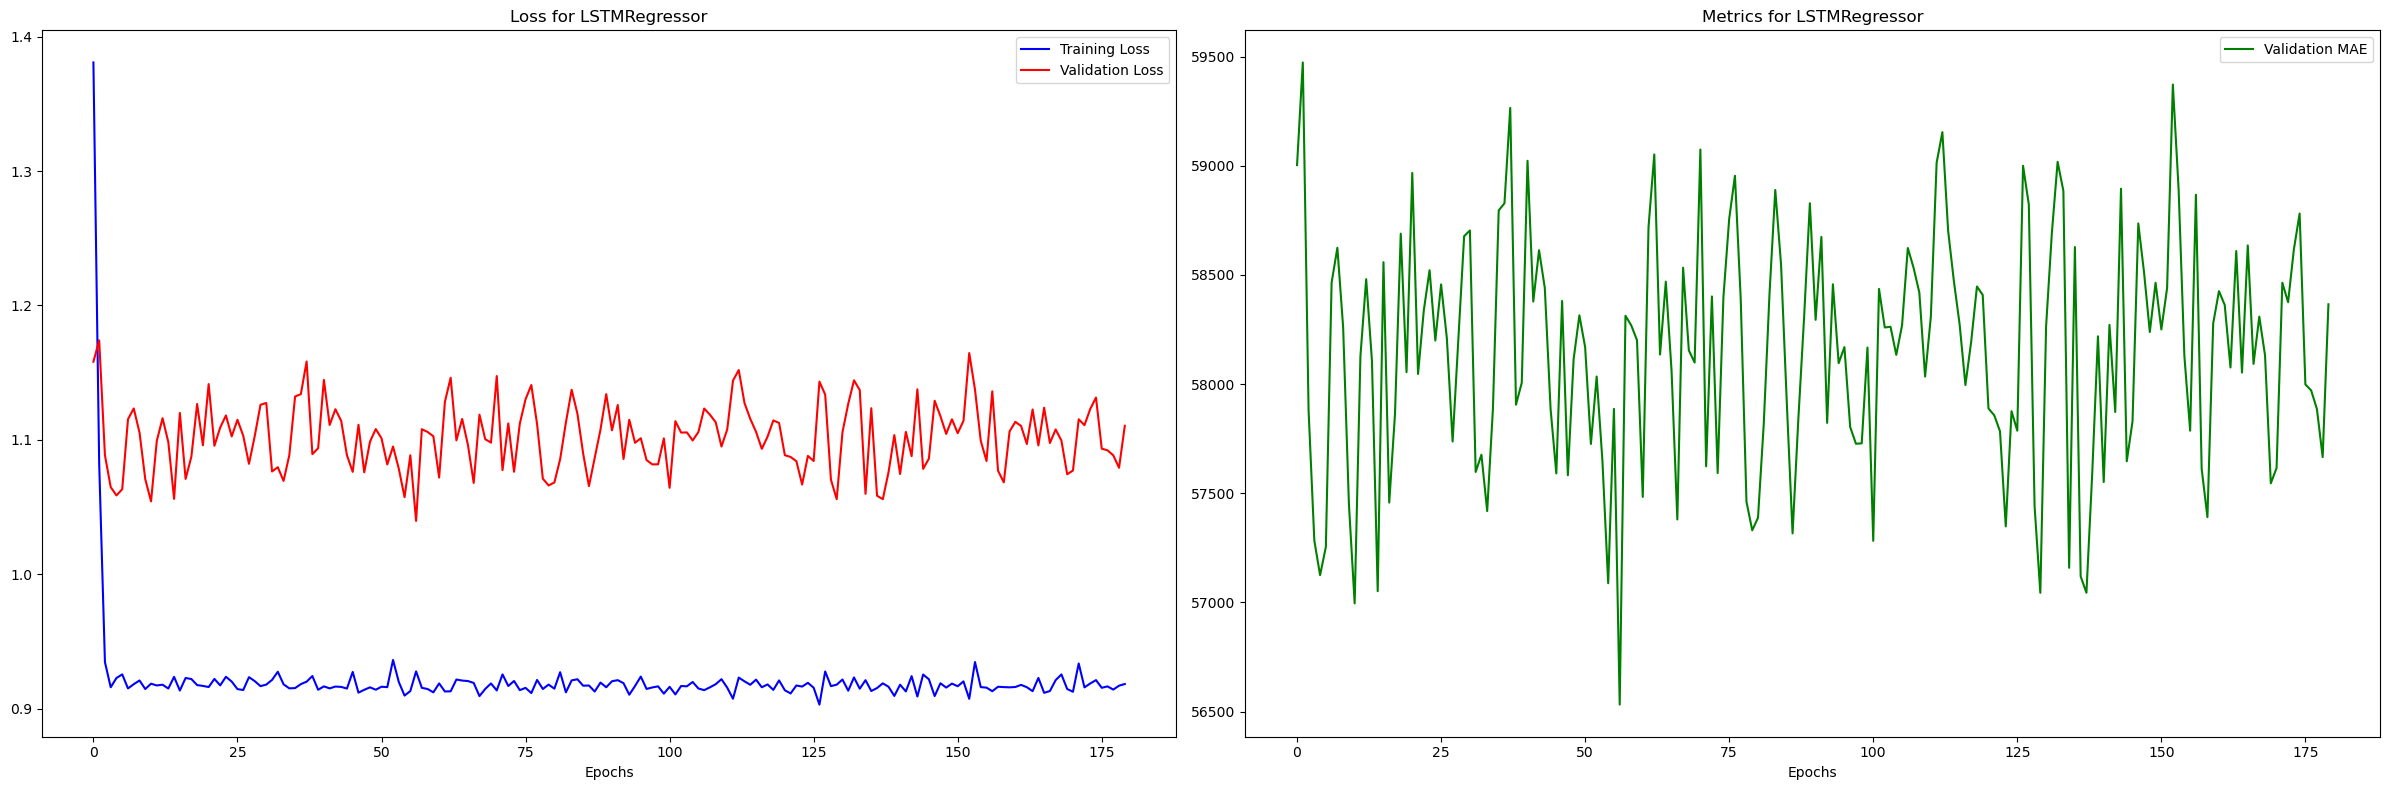

In [28]:
config = load_config("config.yml", "embeddings_sim", "torchRegressor")
seed_everything()
trainer = Training(config, dataset.data_x, y=dataset.data_y, test_X = test_dataset.data_x, cross_validation = False)

pred1 = trainer.average_prediction()
pred2 = trainer.weighted_average_prediction(model_wise=[0.29, 0.33, 0.38], fold_wise=[0.30, 0.35, 0.35])

In [29]:
trainer.trained_models

[GRURegressor(
   (gru): GRU(39, 2, num_layers=2, batch_first=True)
   (linear): Sequential(
     (0): Linear(in_features=22, out_features=1024, bias=True)
     (1): Dropout(p=0.3, inplace=False)
     (2): ReLU()
     (3): Linear(in_features=1024, out_features=512, bias=True)
     (4): Dropout(p=0.3, inplace=False)
     (5): ReLU()
   )
   (head1): Linear(in_features=512, out_features=1, bias=True)
   (loss1): MSELoss()
   (loss3): L1Loss()
 ),
 ConvRegressor(
   (conv_block): Sequential(
     (0): Conv1d(1, 8, kernel_size=(5,), stride=(1,))
     (1): Dropout(p=0.3, inplace=False)
     (2): Conv1d(8, 8, kernel_size=(5,), stride=(1,))
     (3): ReLU()
     (4): Conv1d(8, 16, kernel_size=(5,), stride=(2,))
     (5): Dropout(p=0.3, inplace=False)
     (6): AvgPool1d(kernel_size=(11,), stride=(11,), padding=(0,))
     (7): Conv1d(16, 4, kernel_size=(3,), stride=(3,))
     (8): Flatten(start_dim=1, end_dim=-1)
   )
   (linear): Sequential(
     (0): Linear(in_features=20, out_features=1024,

## Тренировка Бустингов

### Эмбединги

In [ ]:
# config = load_config("config.yml", "embeddings", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Векторное представление + similarity

In [ ]:
# config = load_config("config.yml", "mol_similarity", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Дескрипторы

In [ ]:
# config = load_config("config.yml", "descriptors", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Эмбеддинги + дескрипторы

In [ ]:
# config = load_config("config.yml", "embeddings_descriptors", "SmallNN")
# regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
# regression_models.fit_and_evaluate()

### Эмбеддинги + similarity

Catboost
0:	learn: 0.9559665	test: 1.0588623	best: 1.0588623 (0)	total: 47ms	remaining: 1m 34s
1:	learn: 0.9163972	test: 1.0205535	best: 1.0205535 (1)	total: 69.7ms	remaining: 1m 9s
2:	learn: 0.8895482	test: 0.9906768	best: 0.9906768 (2)	total: 99.3ms	remaining: 1m 6s
3:	learn: 0.8639993	test: 0.9709312	best: 0.9709312 (3)	total: 126ms	remaining: 1m 3s
4:	learn: 0.8354017	test: 0.9441991	best: 0.9441991 (4)	total: 149ms	remaining: 59.6s
5:	learn: 0.8091539	test: 0.9249322	best: 0.9249322 (5)	total: 173ms	remaining: 57.4s
6:	learn: 0.7810675	test: 0.9015506	best: 0.9015506 (6)	total: 193ms	remaining: 55s
7:	learn: 0.7648642	test: 0.8863756	best: 0.8863756 (7)	total: 214ms	remaining: 53.4s
8:	learn: 0.7443781	test: 0.8688454	best: 0.8688454 (8)	total: 239ms	remaining: 52.8s
9:	learn: 0.7227933	test: 0.8492502	best: 0.8492502 (9)	total: 264ms	remaining: 52.5s
10:	learn: 0.7027477	test: 0.8277988	best: 0.8277988 (10)	total: 292ms	remaining: 52.7s
11:	learn: 0.6864445	test: 0.8132565	best: 

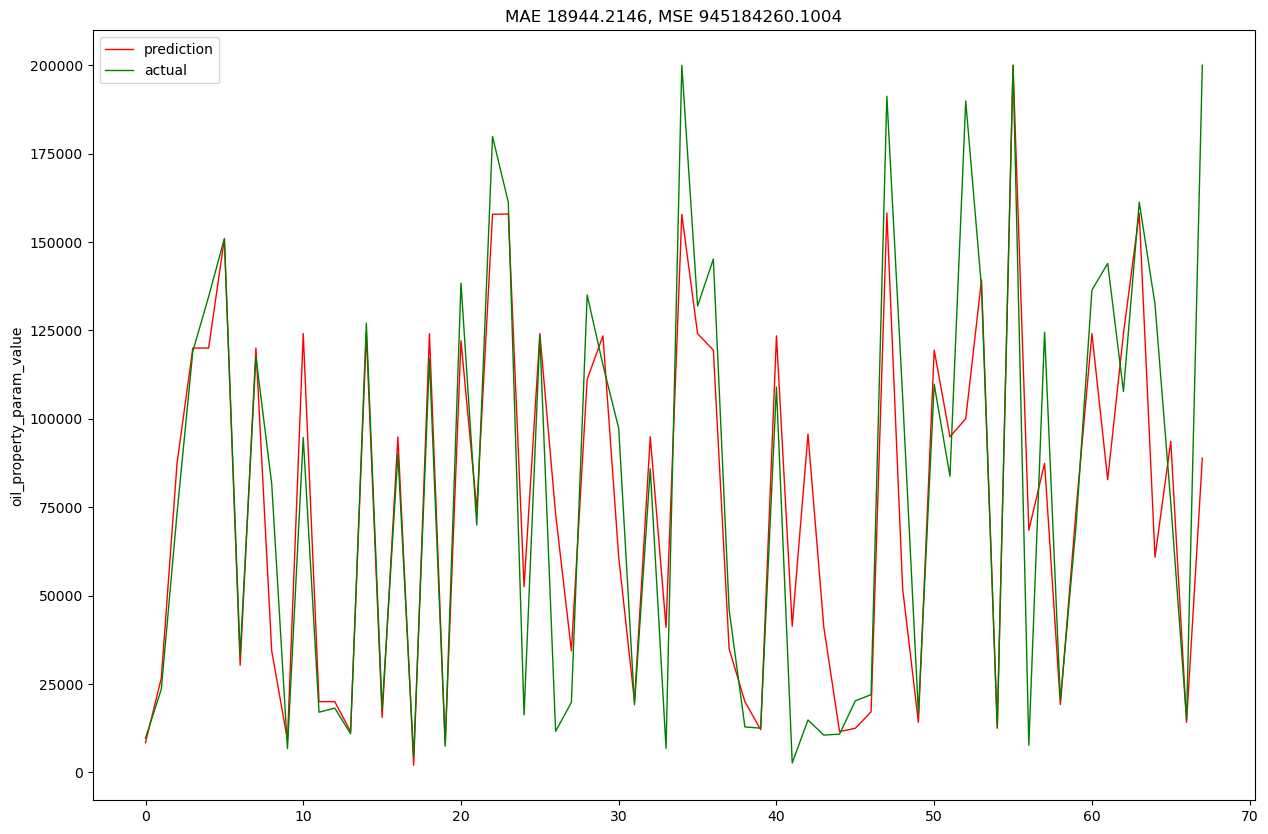

MAE score: 18944.2146
MSE score: 945184260.1004

LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23299
[LightGBM] [Info] Number of data points in the train set: 270, number of used features: 390
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

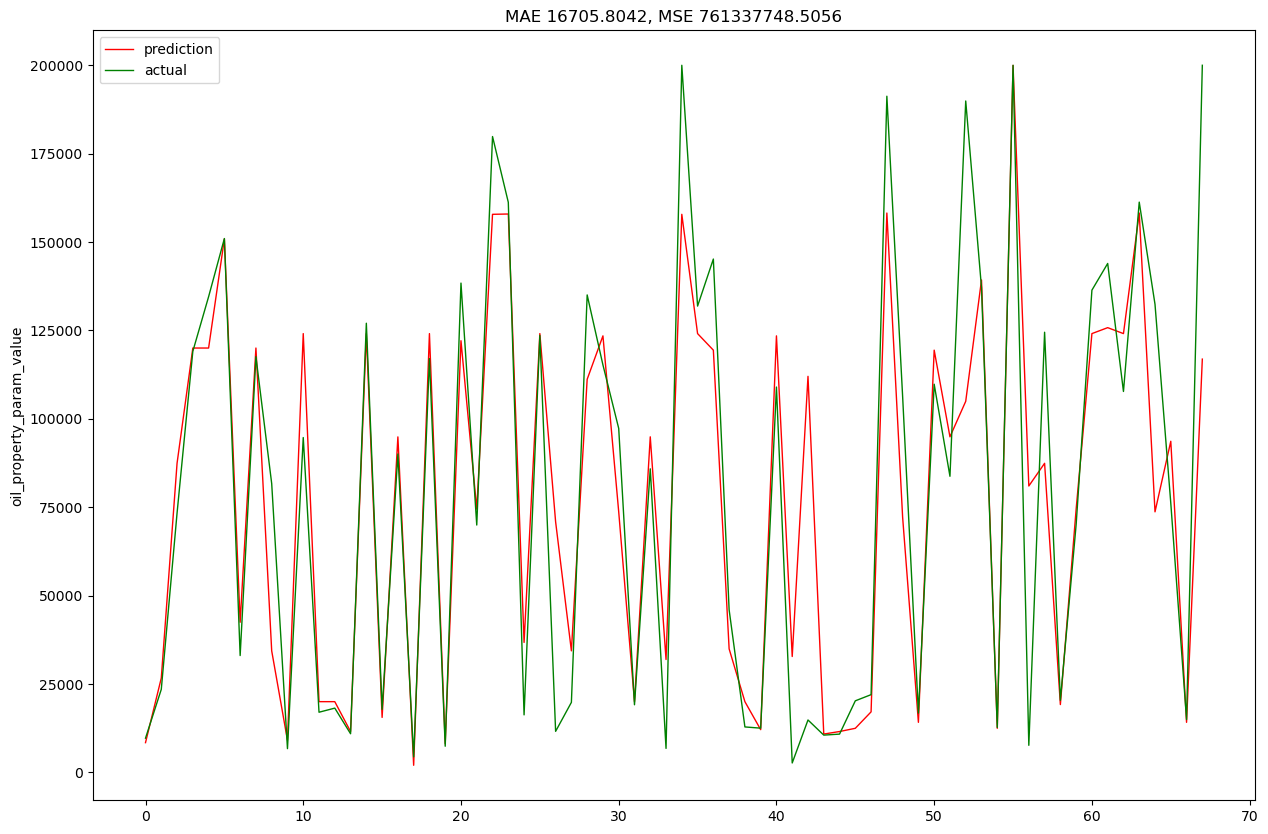

MAE score: 16705.8042
MSE score: 761337748.5056

GradientBoostingRegressor


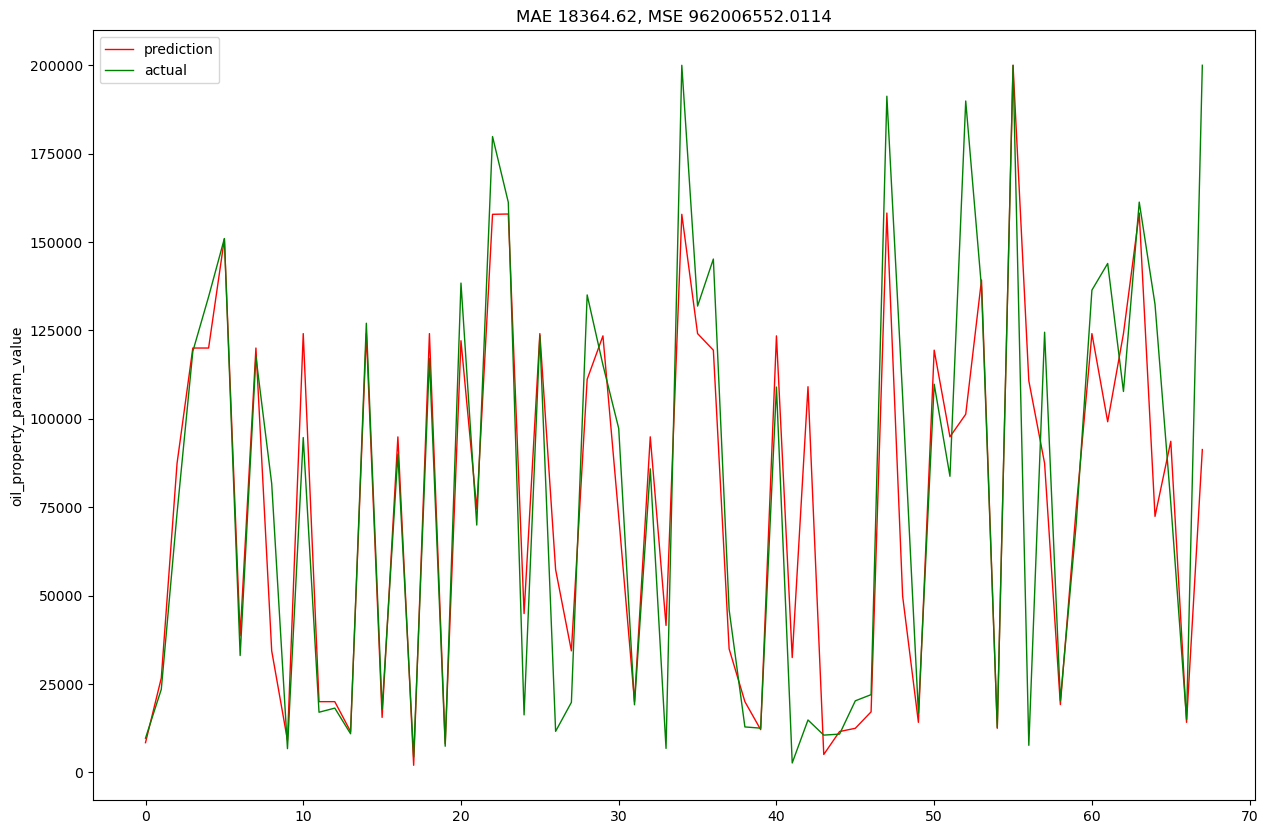

MAE score: 18364.62
MSE score: 962006552.0114

Stack model


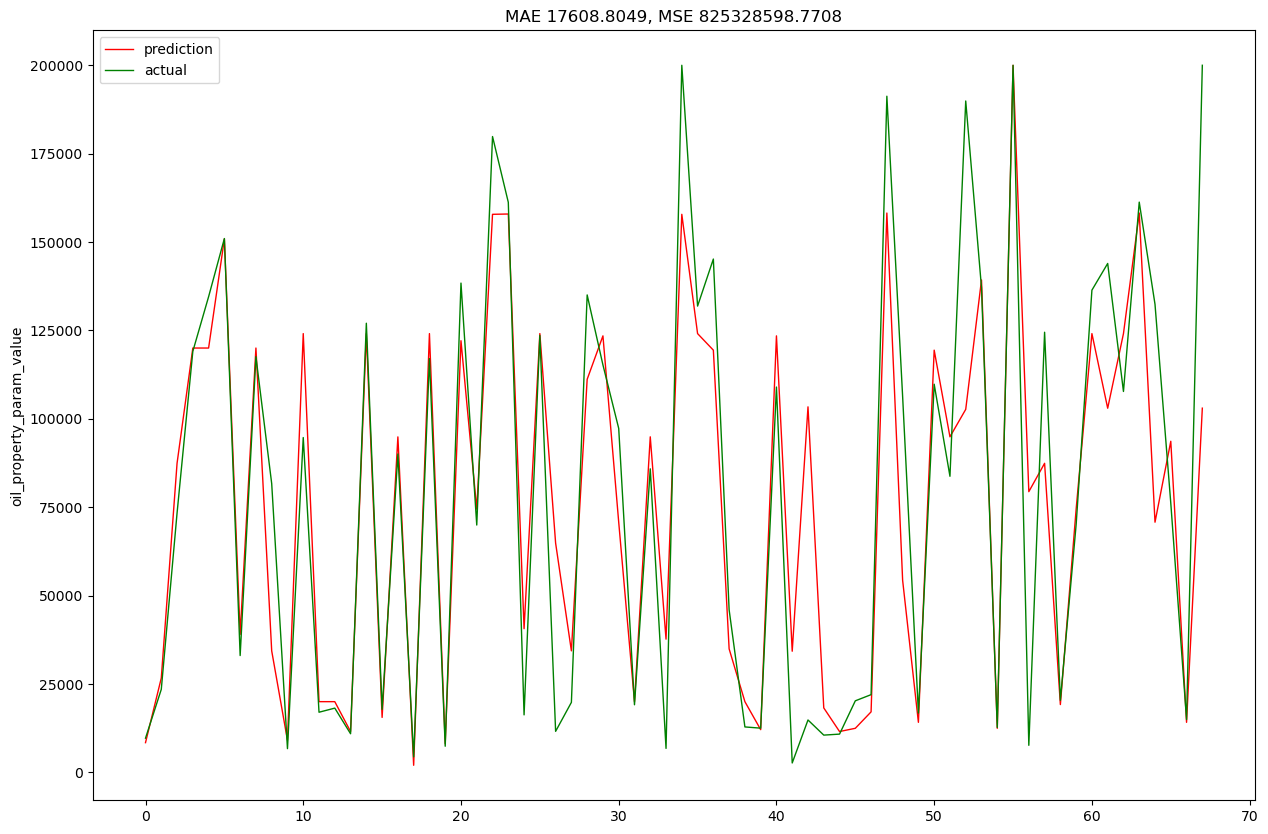

MAE score: 17608.8049
MSE score: 825328598.7708


In [30]:
config = load_config("config.yml", "embeddings_sim", "SmallNN")
regression_models = SimpleRegressions(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), test_X = test_dataset.data_x.reshape(config['input_test']))
regression_models.fit_and_evaluate()

## Pedict Regressos

In [36]:

_, _, _, _, preds = regression_models.ridge_test()

joined_df_test['predictions'] = preds
inference_regressors = joined_df_test[['blend_id', 'predictions']]
inference_regressors['pred1'] = pred1
inference_regressors['pred2'] = pred2

In [32]:
inference_regressors.to_csv(path_or_buf='./materials/inference_regressors.csv', index=False)

In [35]:
inference_regressors


,blend_id,predictions,pred1,pred2
0,0189e1f2-2ab8-11ee-8be1-005056921581,72225.616680,40754.429688,12788.841797
1,02114c6e-eb16-11ed-9974-005056921581,63791.151193,78660.398438,22682.296875
2,03ac1c22-6af9-11ed-8d22-005056921581,74221.482947,85422.898438,24447.308594
3,03b8daf4-a615-11ee-9529-005056921581,54838.589234,97507.835938,27601.480469
4,051562fa-a8e7-11ec-9d4e-005056921581,75300.113402,42224.855469,13172.621094
...,...,...,...,...
133,f1f40fea-2eac-11ed-8c6c-005056921581,68427.892375,85443.578125,24452.710938
134,f38ac89a-b59d-11ec-8ff7-005056921581,67348.656990,73645.757812,21373.480469
135,f72b4fa2-ca49-11ee-94c1-005056921581,66334.843619,86371.804688,24694.976562
136,f7ff118c-eb17-11ed-9974-005056921581,78230.597729,95469.968750,27069.597656


In [ ]:
# from utils import SmallNN

# nn_model = SmallNN(X=dataset.data_x.reshape(config['input']), y=dataset.data_y.reshape(config['input'][0]), config=config)
# nn_model.fit_and_evaluate()

In [ ]:
# from sklearn.model_selection import train_test_split
# scaler_ = StandardScaler() # RobustScaler

# regressor = LstmRegressor(units=50, dropout_rate=0.005, optimizer='rmsprop', epochs=200, 
#                           batch_size=8, neurons_1 = 128, neurons_2 = 64, scaler=scaler_)

# X_train, X_test, y_train, y_test = train_test_split(
#             dataset.data_x.reshape(config['input']), dataset.data_y.reshape(config['input'][0]), test_size=0.2, random_state=42
#         )
# model, _ = regressor.fit(X_train, y_train, X_test, y_test)